## CUSTOMER SEGMENTATION

Firstly, declaring necessary libraries

In [1]:
# for data analysis
import pandas as pd
import numpy as np

import json     # for reading the key inside the json formatted file

# for data visualization
import matplotlib.pyplot as plt

import pyodbc   # for connecting database

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

> Connecting to Database

Pyodbc library handles the connection between Jupyter notebook and MS SQL Server. SQL Server's key is hidden inside the json file.

In [3]:
f = open('log.json')
sql_key = json.load(f)     # returns JSON object as a dictionary

cnxn = pyodbc.connect(sql_key['key'])     # establish a connection
crsr = cnxn.cursor()                      # cursor enables to send command

> Sending Queries 

Queries are sent with respect to the decisions given on analytics phase. G and T type company data are retrieved separately.

>> For G (Şahıs)

**bk_data** table is derived by using **dataset** table on MS SQL. It has been derived using a script which is available below.

In [4]:
gk_query= """SELECT ID, MUSTERI_ID, SIRKET_TURU,
            CEK_NO, CEK_TUTAR, KULLANDIRIM, SUBE, KESIDECI_ID,
            BK_KURUMSAYISI, BK_LIMIT, BK_RISK, BK_GECIKMEHESAP, BK_GECIKMEBAKIYE
            FROM dataset
            WHERE SIRKET_TURU='G' """
g_company_type_df = pd.read_sql(gk_query, cnxn)

In [5]:
g_company_type_df.head(10)

,ID,MUSTERI_ID,SIRKET_TURU,CEK_NO,CEK_TUTAR,KULLANDIRIM,SUBE,KESIDECI_ID,BK_KURUMSAYISI,BK_LIMIT,BK_RISK,BK_GECIKMEHESAP,BK_GECIKMEBAKIYE
0,2457932,11800527,G,70331933,20000,KY,PENDIK,11535476,0,0,0,0,0
1,2457933,12024009,G,3014103,25000,KV,ÇORLU,11753282,3,2213,226,2,1012
2,2457934,11800527,G,7031933,20000,KV,PENDIK,11535476,0,0,0,0,0
3,2457936,11724283,G,7198012,23000,KY,TOPÇULAR,126553,2,52100,9481,3,3575
4,2457937,11879266,G,9090937,10000,KY,ADANA,98511,7,280101,211301,3,4128
5,2457938,11879266,G,9090936,13458,KY,ADANA,98511,7,280101,211301,3,4128
6,2457939,11854083,G,4535918,5200,KY,IZMIT,12054732,0,0,0,0,0
7,2457942,11654711,G,88624,110000,KY,BESEVLER,74198,4,215261,150619,1,847
8,2457943,11723432,G,3331313,5300,KY,YILDIRIM,11570468,4,104384,65599,3,2591
9,2457944,11577211,G,4602258,11000,KY,BEYLIKDÜZÜ,12054730,4,215860,85589,4,6379


>> For T (Tüzel)

In [6]:
tk_query= """SELECT MUSTERI_ID, ID, CEK_NO, CEK_TUTAR, VADE_GUN, TK_NAKDILIMIT, TK_NAKDIRISK, TK_GAYRINAKDILIMIT, TK_GAYRINAKDIRISK, TK_GECIKMEHESAP,
    TK_GECIKMEBAKIYE, TK_KURUMSAYISI, T2_NAKDILIMIT_TPL ,T2_NAKDIRISK_TPL ,T2_NAKDIRISK_KV ,T2_NAKDIRISK_OV ,T2_NAKDIRISK_UV,
    T2_GAYRINAKDILIMIT, T2_GAYRINAKDIRISK ,T2_FKTRNG_LIMIT ,T2_FKTRNG_TPLRISK ,T2_SORUNLUKOD_RISK,
    T3_NAKDILIMIT_TPL,T3_NAKDIRISK_TPL,T3_NAKDIRISK_KV,T3_NAKDIRISK_OV,T3_NAKDIRISK_UV,T3_GAYRINAKDILIMIT,T3_GAYRINAKDIRISK,
    T3_FKTRNG_LIMIT,T3_FKTRNG_TPLRISK,T3_SORUNLUKOD_RISK,T4_NAKDILIMIT_TPL,T4_NAKDIRISK_TPL,T4_NAKDIRISK_KV,T4_NAKDIRISK_OV,
    T4_NAKDIRISK_UV,T4_GAYRINAKDILIMIT,T4_GAYRINAKDIRISK,T4_FKTRNG_LIMIT,T4_FKTRNG_TPLRISK ,T4_SORUNLUKOD_RISK
FROM dbo.dataset WHERE SIRKET_TURU LIKE 'T' """
t_company_type_df = pd.read_sql(tk_query, cnxn)

### MACHINE LEARNING

The ML is going to be implemented to segment customer portfolio into clusters based on their risks. Firstly, the customer portfolio divided into two groups: T type and G type customers. Due to the differences between their attributes, this was inevitable step to be done. Also, it is crucial to define type of machine learning. Due to the attributes, it will be unsupervised learning. As observed, all attributes will be used are features. For providing accurate solution, we obtained that classification of the customer portfolio is a must requirements. In this sense, **K-means** is going to implemented.

Next, the datasets will be prepared for the clustering. There is a need of deriving new attributes by using existing ones. Thus, the feature extraction must be done before putting data into model. In addition to this, data scaling is another significant task to complete. According to Dong, Zhang, and Chen (2020), *data scaling is a technique used in machine learning to adjust the range of features in a dataset, typically to a common scale between zero and one or -1 and 1.* The purpose of data scaling is to standardize the data, mitigate the impact of outliers, and ensure that all features are treated equally during model training. As stated in the paper, we are looking forward to handle large range of magnitudes with this method.

Also, data will be divided into two as training and test for ML. Sarkar and Bali (2020) stated that training dataset is used to teach the algorithm to recognize patterns in the data, while the testing dataset is used to evaluate the algorithm's ability to generalize to new data. We are going to determine whether the model is good fit or not by using test dataset. It is a common fact that overfitting or underfitting models my occur during ML researches.

Moreover, the optimal number of clusters are going to be obtained by using Elbow Method from the data. The elbow method is a critical technique for selecting the optimal number of clusters in k-means clustering, as it provides an objective way to determine the appropriate number of clusters and helps to prevent overfitting and improve the interpretability of the resulting clusters (Tang & Zhang, 2019). After this, we are going to train the model with the train dataset.

After these steps, the accuracy of K-means model must be found out. Also, other appropriate unsupervised ML modelling techniques are going to be compared. The most fitting model's results are going to be saved into the database. The database is going to be integrated our data-oriented web application for strong Business Intelligence presentation.

To conclude, our steps are;

*   Feature Extraction
*   Scaling Data
*   Elbow Method
*   Cross-Validation
*   Comparing K-means with Other Models
*   Saving Results into Database
*   Presenting Results via Streamlit Web-App

> Handle Data Types *-for G type Customers*

For G type Customers, a new empty table is created as **bk_data** on the database. Then, G type customers' records are committed into the table using the following script. The code snippet is commented because we do not need to execute it again. The table is already committed successfully.

Firstly, we have to assign data types before ML operations

In [7]:
g_company_type_df.info()    # to see the data types and missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229538 entries, 0 to 229537
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   ID                229538 non-null  int64 
 1   MUSTERI_ID        229538 non-null  object
 2   SIRKET_TURU       229538 non-null  object
 3   CEK_NO            229538 non-null  object
 4   CEK_TUTAR         229538 non-null  object
 5   KULLANDIRIM       229538 non-null  object
 6   SUBE              229538 non-null  object
 7   KESIDECI_ID       229538 non-null  object
 8   BK_KURUMSAYISI    229538 non-null  object
 9   BK_LIMIT          229538 non-null  object
 10  BK_RISK           229538 non-null  object
 11  BK_GECIKMEHESAP   229538 non-null  object
 12  BK_GECIKMEBAKIYE  229538 non-null  object
dtypes: int64(1), object(12)
memory usage: 22.8+ MB


In [8]:

# there are several characters in the MUSTERI_ID column, so we need to remove them
g_company_type_df['MUSTERI_ID']=g_company_type_df['MUSTERI_ID'].str.replace(r'\D', '').astype(int)
g_company_type_df['ID']=g_company_type_df['ID'].astype(int)

# converting into float to use on ML model later
g_company_type_df['BK_LIMIT']=g_company_type_df['BK_LIMIT'].astype(float)
g_company_type_df['BK_RISK']=g_company_type_df['BK_RISK'].astype(float)
g_company_type_df['BK_GECIKMEHESAP']=g_company_type_df['BK_GECIKMEHESAP'].astype(float)
g_company_type_df['BK_GECIKMEBAKIYE']=g_company_type_df['BK_GECIKMEBAKIYE'].astype(float)


*CEK_NO* has several improper values, so we need to handle errors and convert it into integer

In [9]:
# used these queries to spot the non-integer values
"""SELECT [CEK_NO]
FROM [faktoring_db].[dbo].[dataset]
WHERE CEK_NO like '%[^a-Z0-9]%'

SELECT CEK_NO, COUNT(*) as count
FROM [faktoring_db].[dbo].[dataset]
WHERE CEK_NO like '%[^a-Z0-9]%'
GROUP BY CEK_NO
HAVING COUNT(*) > 0

//OR USE THIS, MORE EFFICIENT RESULTS

SELECT [ID],[CEK_NO]
FROM [faktoring_db].[dbo].[dataset]
WHERE ISNUMERIC([CEK_NO]) <> 1;"""

"SELECT [CEK_NO]\nFROM [faktoring_db].[dbo].[dataset]\nWHERE CEK_NO like '%[^a-Z0-9]%'\n\nSELECT CEK_NO, COUNT(*) as count\nFROM [faktoring_db].[dbo].[dataset]\nWHERE CEK_NO like '%[^a-Z0-9]%'\nGROUP BY CEK_NO\nHAVING COUNT(*) > 0\n\n//OR USE THIS, MORE EFFICIENT RESULTS\n\nSELECT [ID],[CEK_NO]\nFROM [faktoring_db].[dbo].[dataset]\nWHERE ISNUMERIC([CEK_NO]) <> 1;"

Solved the issue on MS SQL with the following script below:

In [10]:
#...and solved the issue by using the following queries
"""
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 1
WHERE [ID] = 2770334;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 2
WHERE [ID] = 2494076;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 3
WHERE [ID] = 2501347;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 4
WHERE [ID] = 2551433;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 5
WHERE [ID] = 2551434;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 6
WHERE [ID] = 2633345;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 7
WHERE [ID] = 2689531;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 8
WHERE [ID] = 2699745;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 9
WHERE [ID] = 2703751;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 10
WHERE [ID] = 2715934;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 11
WHERE [ID] = 2828009;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 12
WHERE [ID] = 2828010;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 13
WHERE [ID] = 2828011;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 14
WHERE [ID] = 2828012;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 15
WHERE [ID] = 2828013;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 16
WHERE [ID] = 2516070 OR
	[ID] = 2525905 OR
	[ID] = 2573048 OR
	[ID] = 2685207 OR
	[ID] = 2727249;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 17
WHERE [ID] = 2741161;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 18
WHERE [ID] = 2766289;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 19
WHERE [ID] = 2809942;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 20
WHERE [ID] = 2815551;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 21
WHERE [ID] = 2850473;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 22
WHERE [ID] = 2911050;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 23
WHERE [ID] = 2912888;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 24
WHERE [ID] = 2912889;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 25
WHERE [ID] = 2922915;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 26
WHERE [ID] = 2922916;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 27
WHERE [ID] = 2923795;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 28
WHERE [ID] = 2703536;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 29
WHERE [ID] = 2740283;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 30
WHERE [ID] = 2622979;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 31
WHERE [ID] = 2740284;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 32
WHERE [ID] = 2740285;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 33
WHERE [ID] = 2740286;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 34
WHERE [ID] = 2740287;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 35
WHERE [ID] = 2740288;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 36
WHERE [ID] = 2740289;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 37
WHERE [ID] = 2740290;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 38
WHERE [ID] = 2780745;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 39
WHERE [ID] = 2782835;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 40
WHERE [ID] = 2782836;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 41
WHERE [ID] = 2823409;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 42
WHERE [ID] = 2823497;
"""

'\nUPDATE [faktoring_db].[dbo].[dataset]\nSET [CEK_NO] = 1\nWHERE [ID] = 2770334;\n\nUPDATE [faktoring_db].[dbo].[dataset]\nSET [CEK_NO] = 2\nWHERE [ID] = 2494076;\n\nUPDATE [faktoring_db].[dbo].[dataset]\nSET [CEK_NO] = 3\nWHERE [ID] = 2501347;\n\nUPDATE [faktoring_db].[dbo].[dataset]\nSET [CEK_NO] = 4\nWHERE [ID] = 2551433;\n\nUPDATE [faktoring_db].[dbo].[dataset]\nSET [CEK_NO] = 5\nWHERE [ID] = 2551434;\n\nUPDATE [faktoring_db].[dbo].[dataset]\nSET [CEK_NO] = 6\nWHERE [ID] = 2633345;\n\nUPDATE [faktoring_db].[dbo].[dataset]\nSET [CEK_NO] = 7\nWHERE [ID] = 2689531;\n\nUPDATE [faktoring_db].[dbo].[dataset]\nSET [CEK_NO] = 8\nWHERE [ID] = 2699745;\n\nUPDATE [faktoring_db].[dbo].[dataset]\nSET [CEK_NO] = 9\nWHERE [ID] = 2703751;\n\nUPDATE [faktoring_db].[dbo].[dataset]\nSET [CEK_NO] = 10\nWHERE [ID] = 2715934;\n\nUPDATE [faktoring_db].[dbo].[dataset]\nSET [CEK_NO] = 11\nWHERE [ID] = 2828009;\n\nUPDATE [faktoring_db].[dbo].[dataset]\nSET [CEK_NO] = 12\nWHERE [ID] = 2828010;\n\nUPDATE [fa

In [11]:
# finally, the script is executed successfully
g_company_type_df['CEK_NO']=g_company_type_df['CEK_NO'].astype('int64')

In [12]:
g_company_type_df['KESIDECI_ID'] = g_company_type_df['KESIDECI_ID'].str.replace(r'\D', '').astype('int')

g_company_type_df['SIRKET_TURU'] = g_company_type_df['SIRKET_TURU'].astype('string')
g_company_type_df['SUBE'] = g_company_type_df['SUBE'].astype('string')
g_company_type_df['KULLANDIRIM'] = g_company_type_df['KULLANDIRIM'].astype('string')

g_company_type_df['CEK_TUTAR'] = g_company_type_df['CEK_TUTAR'].replace(',','.', regex=True).astype('float')
g_company_type_df['BK_KURUMSAYISI'] = g_company_type_df['BK_KURUMSAYISI'].astype('int')

In [13]:
# checking uniqueness of ID
g_company_type_df['ID'].is_unique

#to see the data types after the changes
g_company_type_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229538 entries, 0 to 229537
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                229538 non-null  int32  
 1   MUSTERI_ID        229538 non-null  int32  
 2   SIRKET_TURU       229538 non-null  string 
 3   CEK_NO            229538 non-null  int64  
 4   CEK_TUTAR         229538 non-null  float64
 5   KULLANDIRIM       229538 non-null  string 
 6   SUBE              229538 non-null  string 
 7   KESIDECI_ID       229538 non-null  int32  
 8   BK_KURUMSAYISI    229538 non-null  int32  
 9   BK_LIMIT          229538 non-null  float64
 10  BK_RISK           229538 non-null  float64
 11  BK_GECIKMEHESAP   229538 non-null  float64
 12  BK_GECIKMEBAKIYE  229538 non-null  float64
dtypes: float64(5), int32(4), int64(1), string(3)
memory usage: 19.3 MB


> Feature Extraction

Firstly, exploring the attribute.

In [14]:
g_company_type_df[(g_company_type_df['BK_RISK'] != 0) & (g_company_type_df['BK_LIMIT'] == 0)]   # obtaining the case of RISK is not 0 but LIMIT is 0
g_company_type_df[(g_company_type_df['BK_RISK'] == 0) & (g_company_type_df['BK_LIMIT'] != 0)]   # obtaining the case of RISK is 0 but LIMIT is not 0

,ID,MUSTERI_ID,SIRKET_TURU,CEK_NO,CEK_TUTAR,KULLANDIRIM,SUBE,KESIDECI_ID,BK_KURUMSAYISI,BK_LIMIT,BK_RISK,BK_GECIKMEHESAP,BK_GECIKMEBAKIYE
12,2457952,11860577,G,1023231,12605.49,KY,KAYSERI,134618,1,1000.0,0.0,0.0,0.0
87,2458126,11884594,G,381633,15000.00,KY,ISKENDERUN,30052,2,5200.0,0.0,1.0,296.0
144,2458237,11793964,G,3167451,9500.00,KV,KARABAGLAR,11992164,1,750.0,0.0,0.0,0.0
168,2458278,11593517,G,271555,50000.00,KY,DUDULLU,11592311,1,550.0,0.0,1.0,35.0
177,2458290,11506837,G,8060375,23100.00,KY,ANTALYA,11952661,1,500.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
229377,2939494,11620749,G,1614282,30000.00,KY,MECIDIYEKÖY,104996,2,3000.0,0.0,0.0,0.0
229379,2939497,11855859,G,12927,30000.00,KV,MERSIN,11908808,1,750.0,0.0,0.0,0.0
229400,2939551,124816,G,694134,5000.00,KY,ESKISEHIR,69677,2,1550.0,0.0,3.0,522.0
229401,2939552,124816,G,694133,5000.00,KY,ESKISEHIR,69677,2,1550.0,0.0,3.0,522.0


As seen, there are several cases on the dataframe that one of those attribute is zero while other is not.

We must create a new attribute called **BK_ORAN** which is ***derived by diving BK_RISK to BK_LIMIT***. It will represent as higher ratio provides higher reliability on the customer check payback

*Meanwhile, must be aware of the cases where one of those attributes is equal to 0 and the other is not 0!*

In [15]:
g_company_type_df['BK_ORAN'] = 0    # creating a new column for BK_ORAN and initializing it with 0

# for cases of RISK and LIMIT both are not equal to 0, BK_ORAN is calculated as a ratio of LIMIT to RISK
mask = (g_company_type_df['BK_RISK'] != 0) & (g_company_type_df['BK_LIMIT'] != 0)
g_company_type_df.loc[mask, 'BK_ORAN'] = g_company_type_df.loc[mask, 'BK_LIMIT'] / g_company_type_df.loc[mask, 'BK_RISK']

# for cases of RISK is equal to 0 but LIMIT is not 0, BK_ORAN is calculated as LIMIT / 0.1
mask = (g_company_type_df['BK_RISK'] == 0) & (g_company_type_df['BK_LIMIT'] != 0)
g_company_type_df.loc[mask, 'BK_ORAN'] = g_company_type_df.loc[mask, 'BK_LIMIT'] / 0.1  # assigning the value of RISK as 0.1 instead of 0

# for cases of RISK is not 0 and LIMIT is equal to 0, BK_ORAN is calculated as 0.1 / RISK
mask = (g_company_type_df['BK_LIMIT'] == 0) & (g_company_type_df['BK_RISK'] != 0)
g_company_type_df.loc[mask, 'BK_ORAN'] = 0.1 / g_company_type_df.loc[mask, 'BK_RISK']   # assigning the value of LIMIT as 0.1 instead of 0

mask = (g_company_type_df['BK_LIMIT'] == 0) & (g_company_type_df['BK_RISK'] == 0)
g_company_type_df.loc[mask, 'BK_ORAN'] = 0


The feature extraction is also already committed on the database, so comment this code snippet.

In [16]:
g_company_type_df['BK_ORAN'].describe()                                                     # to see the statistical summary of the data

count    229538.000000
mean        991.941698
std       13452.459457
min           0.000000
25%           1.105593
50%           1.381565
75%           1.936203
max      879000.000000
Name: BK_ORAN, dtype: float64

Another feature extraction will be created below. **Count number of KESIDECI_ID for each customer**

In [30]:
# count the number of unique KESIDECI_ID for each CUSTOMER_ID
g_company_type_df.groupby('MUSTERI_ID')['KESIDECI_ID'].nunique().sort_values(ascending=False)

In [35]:
g_company_type_df.describe()    # to see the statistical summary of the data

,ID,MUSTERI_ID,CEK_NO,CEK_TUTAR,KESIDECI_ID,BK_KURUMSAYISI,BK_LIMIT,BK_RISK,BK_GECIKMEHESAP,BK_GECIKMEBAKIYE,BK_ORAN
count,2.295380e+05,2.295380e+05,2.295380e+05,2.295380e+05,2.295380e+05,229538.000000,2.295380e+05,2.295380e+05,229538.000000,2.295380e+05,229538.000000
mean,2.701168e+06,9.719453e+06,4.185936e+06,2.585948e+04,7.911616e+06,3.123295,6.996197e+04,4.827058e+04,1.928814,2.203242e+03,991.941698
std,1.395355e+05,4.476067e+06,1.920893e+08,6.833846e+04,5.512700e+06,2.247007,1.092359e+05,8.388669e+04,2.176905,1.856836e+04,13452.459457
min,2.457932e+06,1.050000e+02,0.000000e+00,1.000000e+01,2.500000e+01,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,2.580292e+06,1.157367e+07,1.259852e+05,1.000000e+04,1.181500e+05,1.000000,3.797000e+03,1.898000e+03,0.000000,0.000000e+00,1.105593
50%,2.702264e+06,1.176176e+07,1.753388e+06,2.000000e+04,1.165475e+07,3.000000,2.965000e+04,1.599600e+04,1.000000,4.710000e+02,1.381565
75%,2.822914e+06,1.190025e+07,5.370632e+06,3.000000e+04,1.187240e+07,4.000000,9.134800e+04,5.871825e+04,3.000000,2.381000e+03,1.936203
max,2.939795e+06,1.205469e+07,3.930169e+10,3.001202e+07,1.205473e+07,15.000000,2.362133e+06,1.771233e+06,31.000000,2.384798e+06,879000.000000


There is a huge difference between values. We are going to scale data to handle differentiation.

Before scaling, must pivot dataset by customers. Then, divide into training and test datasets.

In [36]:
g_company_type_df['MUSTERI_ID'].value_counts()      # to see the number of occurrence of each customers

11633272    243
48268       176
11550020    170
11529385    161
132381      153
           ... 
11973509      1
35325         1
11791089      1
12029820      1
12016008      1
Name: MUSTERI_ID, Length: 38374, dtype: int64

> Save Changes on Table to Database

In [ ]:
for index, row in g_company_type_df.iterrows():
    crsr.execute("""INSERT INTO bk_dataset (ID, MUSTERI_ID, CEK_NO, CEK_TUTAR,
            KULLANDIRIM, SUBE, KESIDECI_ID, BK_KURUMSAYISI, BK_LIMIT, BK_RISK,
            BK_GECIKMEHESAP, BK_GECIKMEBAKIYE, BK_ORAN)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)""",
            row.ID, row.MUSTERI_ID, row.CEK_NO, row.CEK_TUTAR, row.KULLANDIRIM, row.SUBE, row.KESIDECI_ID,
            row.BK_KURUMSAYISI, row.BK_LIMIT, row.BK_RISK, row.BK_GECIKMEHESAP, row.BK_GECIKMEBAKIYE, row.BK_ORAN)
cnxn.commit()
crsr.close()

Executed the code block above. Committed all data successfully on our database

How table is going to be used on ML be like:

In [ ]:
# pivoting by customers and checks
g_company_type_df.set_index(['ID','MUSTERI_ID','CEK_NO'])

,,,CEK_TUTAR,VADE_GUN,BK_LIMIT,BK_RISK,BK_GECIKMEHESAP,BK_GECIKMEBAKIYE,BK_ORAN
ID,MUSTERI_ID,CEK_NO,,,,,,,
2457932,11800527,70331933,20000.0,100,0.0,0.0,0.0,0.0,0.000000
2457933,12024009,3014103,25000.0,126,2213.0,226.0,2.0,1012.0,9.792035
2457934,11800527,7031933,20000.0,100,0.0,0.0,0.0,0.0,0.000000
2457936,11724283,7198012,23000.0,151,52100.0,9481.0,3.0,3575.0,5.495201
2457937,11879266,9090937,10000.0,151,280101.0,211301.0,3.0,4128.0,1.325602
...,...,...,...,...,...,...,...,...,...
2939791,11708128,8005260,25000.0,332,0.0,0.0,0.0,0.0,0.000000
2939792,11708128,363682,30000.0,347,0.0,0.0,0.0,0.0,0.000000
2939793,11708128,1246339,20000.0,271,0.0,0.0,0.0,0.0,0.000000


> Handle Data Types *-for T type Customers*

For T type Customers...

In [5]:
t_company_type_df.head(5)

,MUSTERI_ID,ID,CEK_NO,CEK_TUTAR,VADE_GUN,TK_NAKDILIMIT,TK_NAKDIRISK,TK_GAYRINAKDILIMIT,TK_GAYRINAKDIRISK,TK_GECIKMEHESAP,...,T4_NAKDILIMIT_TPL,T4_NAKDIRISK_TPL,T4_NAKDIRISK_KV,T4_NAKDIRISK_OV,T4_NAKDIRISK_UV,T4_GAYRINAKDILIMIT,T4_GAYRINAKDIRISK,T4_FKTRNG_LIMIT,T4_FKTRNG_TPLRISK,T4_SORUNLUKOD_RISK
0,11820145,2457923,3062309,8000,20,11000,9490,0,0,0,...,11000,9204,9204,0,0,0,0,190000,68065,0
1,11672216,2457924,80075,35000,91,6903025,3095925,1049450,45637,12,...,17227912,7120280,3305228,0,3815052,5203710,3990632,1928876,1145160,0
2,11672216,2457925,1009838,5000,103,6903025,3095925,1049450,45637,12,...,17227912,7120280,3305228,0,3815052,5203710,3990632,1928876,1145160,0
3,11672216,2457926,1009837,10000,76,6903025,3095925,1049450,45637,12,...,17227912,7120280,3305228,0,3815052,5203710,3990632,1928876,1145160,0
4,11672216,2457927,8005059,15000,182,6903025,3095925,1049450,45637,12,...,17227912,7120280,3305228,0,3815052,5203710,3990632,1928876,1145160,0


In [6]:
t_company_type_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252335 entries, 0 to 252334
Data columns (total 42 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   MUSTERI_ID          252335 non-null  object
 1   ID                  252335 non-null  int64 
 2   CEK_NO              252335 non-null  object
 3   CEK_TUTAR           252335 non-null  object
 4   VADE_GUN            252335 non-null  object
 5   TK_NAKDILIMIT       252335 non-null  object
 6   TK_NAKDIRISK        252335 non-null  object
 7   TK_GAYRINAKDILIMIT  252335 non-null  object
 8   TK_GAYRINAKDIRISK   252335 non-null  object
 9   TK_GECIKMEHESAP     252335 non-null  object
 10  TK_GECIKMEBAKIYE    252335 non-null  object
 11  TK_KURUMSAYISI      252335 non-null  object
 12  T2_NAKDILIMIT_TPL   188786 non-null  object
 13  T2_NAKDIRISK_TPL    188786 non-null  object
 14  T2_NAKDIRISK_KV     188786 non-null  object
 15  T2_NAKDIRISK_OV     188786 non-null  object
 16  T2

There are no null values according to info, but there are values written as "NULL", so we need to convert them into null values

In [7]:
t_company_type_df = t_company_type_df.replace('NULL', None)

Then, assign their data type

In [8]:
t_company_type_df['T4_SORUNLUKOD_RISK'] = t_company_type_df['T4_SORUNLUKOD_RISK'].astype('float')
t_company_type_df['T4_FKTRNG_TPLRISK'] = t_company_type_df['T4_FKTRNG_TPLRISK'].astype('float')
t_company_type_df['T4_FKTRNG_LIMIT'] = t_company_type_df['T4_FKTRNG_LIMIT'].astype('float')
t_company_type_df['T4_GAYRINAKDIRISK'] = t_company_type_df['T4_GAYRINAKDIRISK'].astype('float')
t_company_type_df['T4_GAYRINAKDILIMIT'] = t_company_type_df['T4_GAYRINAKDILIMIT'].astype('float')
t_company_type_df['T4_NAKDIRISK_UV'] = t_company_type_df['T4_NAKDIRISK_UV'].astype('float')
t_company_type_df['T4_NAKDIRISK_OV'] = t_company_type_df['T4_NAKDIRISK_OV'].astype('float')
t_company_type_df['T4_NAKDIRISK_KV'] = t_company_type_df['T4_NAKDIRISK_KV'].astype('float')
t_company_type_df['T4_NAKDIRISK_TPL'] = t_company_type_df['T4_NAKDIRISK_TPL'].astype('float')
t_company_type_df['T4_NAKDILIMIT_TPL'] = t_company_type_df['T4_NAKDILIMIT_TPL'].astype('float')

t_company_type_df['T3_SORUNLUKOD_RISK'] = t_company_type_df['T3_SORUNLUKOD_RISK'].astype('float')
t_company_type_df['T3_FKTRNG_TPLRISK'] = t_company_type_df['T3_FKTRNG_TPLRISK'].astype('float')
t_company_type_df['T3_FKTRNG_LIMIT'] = t_company_type_df['T3_FKTRNG_LIMIT'].astype('float')
t_company_type_df['T3_GAYRINAKDIRISK'] = t_company_type_df['T3_GAYRINAKDIRISK'].astype('float')
t_company_type_df['T3_GAYRINAKDILIMIT'] = t_company_type_df['T3_GAYRINAKDILIMIT'].astype('float')
t_company_type_df['T3_NAKDIRISK_UV'] = t_company_type_df['T3_NAKDIRISK_UV'].astype('float')
t_company_type_df['T3_NAKDIRISK_OV'] = t_company_type_df['T3_NAKDIRISK_OV'].astype('float')
t_company_type_df['T3_NAKDIRISK_KV'] = t_company_type_df['T3_NAKDIRISK_KV'].astype('float')
t_company_type_df['T3_NAKDIRISK_TPL'] = t_company_type_df['T3_NAKDIRISK_TPL'].astype('float')
t_company_type_df['T3_NAKDILIMIT_TPL'] = t_company_type_df['T3_NAKDILIMIT_TPL'].astype('float')

t_company_type_df['T2_SORUNLUKOD_RISK'] = t_company_type_df['T2_SORUNLUKOD_RISK'].astype('float')
t_company_type_df['T2_FKTRNG_TPLRISK'] = t_company_type_df['T2_FKTRNG_TPLRISK'].astype('float')
t_company_type_df['T2_FKTRNG_LIMIT'] = t_company_type_df['T2_FKTRNG_LIMIT'].astype('float')
t_company_type_df['T2_GAYRINAKDIRISK'] = t_company_type_df['T2_GAYRINAKDIRISK'].astype('float')
t_company_type_df['T2_GAYRINAKDILIMIT'] = t_company_type_df['T2_GAYRINAKDILIMIT'].astype('float')
t_company_type_df['T2_NAKDIRISK_UV'] = t_company_type_df['T2_NAKDIRISK_UV'].astype('float')
t_company_type_df['T2_NAKDIRISK_OV'] = t_company_type_df['T2_NAKDIRISK_OV'].astype('float')
t_company_type_df['T2_NAKDIRISK_KV'] = t_company_type_df['T2_NAKDIRISK_KV'].astype('float')
t_company_type_df['T2_NAKDIRISK_TPL'] = t_company_type_df['T2_NAKDIRISK_TPL'].astype('float')
t_company_type_df['T2_NAKDILIMIT_TPL'] = t_company_type_df['T2_NAKDILIMIT_TPL'].astype('float')

t_company_type_df['TK_GAYRINAKDIRISK'] = t_company_type_df['TK_GAYRINAKDIRISK'].astype('float')
t_company_type_df['TK_GAYRINAKDILIMIT'] = t_company_type_df['TK_GAYRINAKDILIMIT'].astype('float')
t_company_type_df['TK_NAKDIRISK'] = t_company_type_df['TK_NAKDIRISK'].astype('float')
t_company_type_df['TK_NAKDILIMIT'] = t_company_type_df['TK_NAKDILIMIT'].astype('float')
t_company_type_df['TK_GECIKMEHESAP'] = t_company_type_df['TK_GECIKMEHESAP'].astype('float')
t_company_type_df['TK_GECIKMEBAKIYE'] = t_company_type_df['TK_GECIKMEBAKIYE'].astype('float')
t_company_type_df['TK_KURUMSAYISI'] = t_company_type_df['TK_KURUMSAYISI'].astype('int')
t_company_type_df['VADE_GUN'] = t_company_type_df['VADE_GUN'].astype('int')

t_company_type_df['CEK_NO'] = t_company_type_df['CEK_NO'].astype('int64')

t_company_type_df['MUSTERI_ID']= t_company_type_df['MUSTERI_ID'].str.replace(r'\D', '').astype(int)
t_company_type_df['MUSTERI_ID'] = t_company_type_df['MUSTERI_ID'].astype('int')

t_company_type_df['CEK_TUTAR'] = t_company_type_df['CEK_TUTAR'].replace(',','.', regex=True).astype('float')

In [9]:
t_company_type_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252335 entries, 0 to 252334
Data columns (total 42 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   MUSTERI_ID          252335 non-null  int32  
 1   ID                  252335 non-null  int64  
 2   CEK_NO              252335 non-null  int64  
 3   CEK_TUTAR           252335 non-null  float64
 4   VADE_GUN            252335 non-null  int32  
 5   TK_NAKDILIMIT       252335 non-null  float64
 6   TK_NAKDIRISK        252335 non-null  float64
 7   TK_GAYRINAKDILIMIT  252335 non-null  float64
 8   TK_GAYRINAKDIRISK   252335 non-null  float64
 9   TK_GECIKMEHESAP     252335 non-null  float64
 10  TK_GECIKMEBAKIYE    252335 non-null  float64
 11  TK_KURUMSAYISI      252335 non-null  int32  
 12  T2_NAKDILIMIT_TPL   188786 non-null  float64
 13  T2_NAKDIRISK_TPL    188786 non-null  float64
 14  T2_NAKDIRISK_KV     188786 non-null  float64
 15  T2_NAKDIRISK_OV     188786 non-nul

Fill Null values with the mean or zero of the relevant attribute

In [131]:
"""t_company_type_df['T4_SORUNLUKOD_RISK'] = t_company_type_df['T4_SORUNLUKOD_RISK'].fillna(value=t_company_type_df['T4_SORUNLUKOD_RISK'].mean(), inplace=True)
t_company_type_df['T4_FKTRNG_TPLRISK'] = t_company_type_df['T4_FKTRNG_TPLRISK'].fillna(value=t_company_type_df['T4_FKTRNG_TPLRISK'].mean(), inplace=True)
t_company_type_df['T4_FKTRNG_LIMIT'] = t_company_type_df['T4_FKTRNG_LIMIT'].fillna(value=t_company_type_df['T4_FKTRNG_LIMIT'].mean(), inplace=True)
t_company_type_df['T4_GAYRINAKDIRISK'] = t_company_type_df['T4_GAYRINAKDIRISK'].fillna(value=t_company_type_df['T4_GAYRINAKDIRISK'].mean(), inplace=True)
t_company_type_df['T4_GAYRINAKDILIMIT'] = t_company_type_df['T4_GAYRINAKDILIMIT'].fillna(value=t_company_type_df['T4_GAYRINAKDILIMIT'].mean(), inplace=True)
t_company_type_df['T4_NAKDIRISK_UV'] = t_company_type_df['T4_NAKDIRISK_UV'].fillna(value=t_company_type_df['T4_NAKDIRISK_UV'].mean(), inplace=True)
t_company_type_df['T4_NAKDIRISK_OV'] = t_company_type_df['T4_NAKDIRISK_OV'].fillna(value=t_company_type_df['T4_NAKDIRISK_OV'].mean(), inplace=True)
t_company_type_df['T4_NAKDIRISK_KV'] = t_company_type_df['T4_NAKDIRISK_KV'].fillna(value=t_company_type_df['T4_NAKDIRISK_KV'].mean(), inplace=True)

t_company_type_df['T3_SORUNLUKOD_RISK'] = t_company_type_df['T3_SORUNLUKOD_RISK'].fillna(value=t_company_type_df['T3_SORUNLUKOD_RISK'].mean(), inplace=True)
t_company_type_df['T3_FKTRNG_TPLRISK'] = t_company_type_df['T3_FKTRNG_TPLRISK'].fillna(value=t_company_type_df['T3_FKTRNG_TPLRISK'].mean(), inplace=True)
t_company_type_df['T3_FKTRNG_LIMIT'] = t_company_type_df['T3_FKTRNG_LIMIT'].fillna(value=t_company_type_df['T3_FKTRNG_LIMIT'].mean(), inplace=True)
t_company_type_df['T3_GAYRINAKDIRISK'] = t_company_type_df['T3_GAYRINAKDIRISK'].fillna(value=t_company_type_df['T3_GAYRINAKDIRISK'].mean(), inplace=True)
t_company_type_df['T3_GAYRINAKDILIMIT'] = t_company_type_df['T3_GAYRINAKDILIMIT'].fillna(value=t_company_type_df['T3_GAYRINAKDILIMIT'].mean(), inplace=True)
t_company_type_df['T3_NAKDIRISK_UV'] = t_company_type_df['T3_NAKDIRISK_UV'].fillna(value=t_company_type_df['T3_NAKDIRISK_UV'].mean(), inplace=True)
t_company_type_df['T3_NAKDIRISK_OV'] = t_company_type_df['T3_NAKDIRISK_OV'].fillna(value=t_company_type_df['T3_NAKDIRISK_OV'].mean(), inplace=True)
t_company_type_df['T3_NAKDIRISK_KV'] = t_company_type_df['T3_NAKDIRISK_KV'].fillna(value=t_company_type_df['T3_NAKDIRISK_KV'].mean(), inplace=True)

t_company_type_df['T2_SORUNLUKOD_RISK'] = t_company_type_df['T2_SORUNLUKOD_RISK'].fillna(value=t_company_type_df['T2_SORUNLUKOD_RISK'].mean(), inplace=True)
t_company_type_df['T2_FKTRNG_TPLRISK'] = t_company_type_df['T2_FKTRNG_TPLRISK'].fillna(value=t_company_type_df['T2_FKTRNG_TPLRISK'].mean(), inplace=True)
t_company_type_df['T2_FKTRNG_LIMIT'] = t_company_type_df['T2_FKTRNG_LIMIT'].fillna(value=t_company_type_df['T2_FKTRNG_LIMIT'].mean(), inplace=True)
t_company_type_df['T2_GAYRINAKDIRISK'] = t_company_type_df['T2_GAYRINAKDIRISK'].fillna(value=t_company_type_df['T2_GAYRINAKDIRISK'].mean(), inplace=True)
t_company_type_df['T2_GAYRINAKDILIMIT'] = t_company_type_df['T2_GAYRINAKDILIMIT'].fillna(value=t_company_type_df['T2_GAYRINAKDILIMIT'].mean(), inplace=True)
t_company_type_df['T2_NAKDIRISK_UV'] = t_company_type_df['T2_NAKDIRISK_UV'].fillna(value=t_company_type_df['T2_NAKDIRISK_UV'].mean(), inplace=True)
t_company_type_df['T2_NAKDIRISK_OV'] = t_company_type_df['T2_NAKDIRISK_OV'].fillna(value=t_company_type_df['T2_NAKDIRISK_OV'].mean(), inplace=True)
t_company_type_df['T2_NAKDIRISK_KV'] = t_company_type_df['T2_NAKDIRISK_KV'].fillna(value=t_company_type_df['T2_NAKDIRISK_KV'].mean(), inplace=True)"""

"t_company_type_df['T4_SORUNLUKOD_RISK'] = t_company_type_df['T4_SORUNLUKOD_RISK'].fillna(value=t_company_type_df['T4_SORUNLUKOD_RISK'].mean(), inplace=True)\nt_company_type_df['T4_FKTRNG_TPLRISK'] = t_company_type_df['T4_FKTRNG_TPLRISK'].fillna(value=t_company_type_df['T4_FKTRNG_TPLRISK'].mean(), inplace=True)\nt_company_type_df['T4_FKTRNG_LIMIT'] = t_company_type_df['T4_FKTRNG_LIMIT'].fillna(value=t_company_type_df['T4_FKTRNG_LIMIT'].mean(), inplace=True)\nt_company_type_df['T4_GAYRINAKDIRISK'] = t_company_type_df['T4_GAYRINAKDIRISK'].fillna(value=t_company_type_df['T4_GAYRINAKDIRISK'].mean(), inplace=True)\nt_company_type_df['T4_GAYRINAKDILIMIT'] = t_company_type_df['T4_GAYRINAKDILIMIT'].fillna(value=t_company_type_df['T4_GAYRINAKDILIMIT'].mean(), inplace=True)\nt_company_type_df['T4_NAKDIRISK_UV'] = t_company_type_df['T4_NAKDIRISK_UV'].fillna(value=t_company_type_df['T4_NAKDIRISK_UV'].mean(), inplace=True)\nt_company_type_df['T4_NAKDIRISK_OV'] = t_company_type_df['T4_NAKDIRISK_OV']

...or this

In [130]:
#t_company_type_df.fillna(0)

In [11]:
t_company_type_df.head(15)

,MUSTERI_ID,ID,CEK_NO,CEK_TUTAR,VADE_GUN,TK_NAKDILIMIT,TK_NAKDIRISK,TK_GAYRINAKDILIMIT,TK_GAYRINAKDIRISK,TK_GECIKMEHESAP,...,T4_NAKDILIMIT_TPL,T4_NAKDIRISK_TPL,T4_NAKDIRISK_KV,T4_NAKDIRISK_OV,T4_NAKDIRISK_UV,T4_GAYRINAKDILIMIT,T4_GAYRINAKDIRISK,T4_FKTRNG_LIMIT,T4_FKTRNG_TPLRISK,T4_SORUNLUKOD_RISK
0,11820145,2457923,3062309,8000.00,20,11000.0,9490.0,0.0,0.0,0.0,...,11000.0,9204.0,9204.0,0.0,0.0,0.0,0.0,190000.0,68065.0,0.0
1,11672216,2457924,80075,35000.00,91,6903025.0,3095925.0,1049450.0,45637.0,12.0,...,17227912.0,7120280.0,3305228.0,0.0,3815052.0,5203710.0,3990632.0,1928876.0,1145160.0,0.0
2,11672216,2457925,1009838,5000.00,103,6903025.0,3095925.0,1049450.0,45637.0,12.0,...,17227912.0,7120280.0,3305228.0,0.0,3815052.0,5203710.0,3990632.0,1928876.0,1145160.0,0.0
3,11672216,2457926,1009837,10000.00,76,6903025.0,3095925.0,1049450.0,45637.0,12.0,...,17227912.0,7120280.0,3305228.0,0.0,3815052.0,5203710.0,3990632.0,1928876.0,1145160.0,0.0
4,11672216,2457927,8005059,15000.00,182,6903025.0,3095925.0,1049450.0,45637.0,12.0,...,17227912.0,7120280.0,3305228.0,0.0,3815052.0,5203710.0,3990632.0,1928876.0,1145160.0,0.0
5,11672216,2457928,7824,5000.00,110,6903025.0,3095925.0,1049450.0,45637.0,12.0,...,17227912.0,7120280.0,3305228.0,0.0,3815052.0,5203710.0,3990632.0,1928876.0,1145160.0,0.0
6,11672216,2457929,5425083,6000.00,90,6903025.0,3095925.0,1049450.0,45637.0,12.0,...,17227912.0,7120280.0,3305228.0,0.0,3815052.0,5203710.0,3990632.0,1928876.0,1145160.0,0.0
7,11672216,2457930,84781,77600.00,181,6903025.0,3095925.0,1049450.0,45637.0,12.0,...,17227912.0,7120280.0,3305228.0,0.0,3815052.0,5203710.0,3990632.0,1928876.0,1145160.0,0.0
8,11672216,2457931,17971,100000.00,151,6903025.0,3095925.0,1049450.0,45637.0,12.0,...,17227912.0,7120280.0,3305228.0,0.0,3815052.0,5203710.0,3990632.0,1928876.0,1145160.0,0.0
9,11827634,2457935,1012285,22000.00,120,931624.0,0.0,932564.0,2820.0,0.0,...,0.0,0.0,0.0,0.0,0.0,940.0,940.0,3090000.0,403035.0,0.0


In [15]:
t_company_type_df['T4_FKTRNG_LIMIT'].value_counts()

190000.0     12148
150000.0      9469
0.0           9164
390000.0      5380
350000.0      4986
             ...  
113000.0         1
1184838.0        1
978762.0         1
2206500.0        1
1632676.0        1
Name: T4_FKTRNG_LIMIT, Length: 10261, dtype: int64

> Scaling Data

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [19]:
# selecting the columns to be scaled
columns_to_scale = ['CEK_TUTAR', 'VADE_GUN', 'BK_GECIKMEBAKIYE', 'BK_ORAN']

scaled_df = g_company_type_df[columns_to_scale]         # creating a new dataframe with the selected columns

In [20]:
scaled_data = scaler.fit_transform(scaled_df)                       # fit and transform the data
scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale)     # convert the scaled data array back into a DataFrame

g_company_type_df[columns_to_scale] = scaled_df                     # finally, assign the scaled values back to the main original dataFrame

In [21]:
g_company_type_df.head(5)

,MUSTERI_ID,CEK_NO,CEK_TUTAR,VADE_GUN,BK_GECIKMEHESAP,BK_GECIKMEBAKIYE,BK_ORAN
0,11800527,70331933,-0.085742,-0.285251,0.0,-0.118656,-0.073737
1,12024009,3014103,-0.012577,0.164097,2.0,-0.064155,-0.073009
2,11800527,7031933,-0.085742,-0.285251,0.0,-0.118656,-0.073737
3,11724283,7198012,-0.041843,0.596162,3.0,0.073876,-0.073328
4,11879266,9090937,-0.232073,0.596162,3.0,0.103658,-0.073638


> Training/Test Data Split

Creating two datasets which stands for testing and training. Their ratio is 8/2 as mostly used in ML studies. The train dataset is going to be used to put into the model. The testing data -which has 2 ratio- substituted to calculate the silhouette score of model.

In [ ]:
from sklearn.model_selection import train_test_split

In [26]:
# selecting the input columns for clustering
feature_columns = ['CEK_TUTAR', 'VADE_GUN', 'BK_GECIKMEHESAP', 'BK_GECIKMEBAKIYE', 'BK_ORAN']

In [ ]:
# splitting the data into training and test sets by 8/2 ratio
X_train, X_test = train_test_split(g_company_type_df[feature_columns], test_size=0.2, random_state=42)

> Elbow Method

We aim to maximize the efficiency of segmentation while minimizing the number of clusters. In this sense, Elbow Method is crucial concept to satisfy this requirement.

In [22]:
# importing scikit-learning library for the K-means model
from sklearn.cluster import KMeans

In [27]:
def find_optimal_clusters(df, maximum_K):
    clusters_centers = []   # appending inertia value coming from the model
    k_values = []           # putting k values from 0 to maximum K

    for k in range(1, maximum_K):
        kmeans_model = KMeans(n_clusters = k)
        kmeans_model.fit(df)

        clusters_centers.append(kmeans_model.inertia_)
        k_values.append(k)

    return clusters_centers, k_values

*Note About **Inertia***:

Inertia measures how well a dataset was clustered by K-Means. It is calculated by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster. **A good model is one with low inertia** and **a low number of clusters** (K) *-Codeacademy*

In the next step, illustrating an elbow method for the data

In [24]:
def generate_elbow_plot(clusters_centers, k_values):
    figure = plt.subplots(figsize = (12, 6))
    plt.plot(k_values, clusters_centers, 'o-', color = 'blue')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Cluster Inertia")
    plt.title("Elbow Plot of Model")
    plt.show()

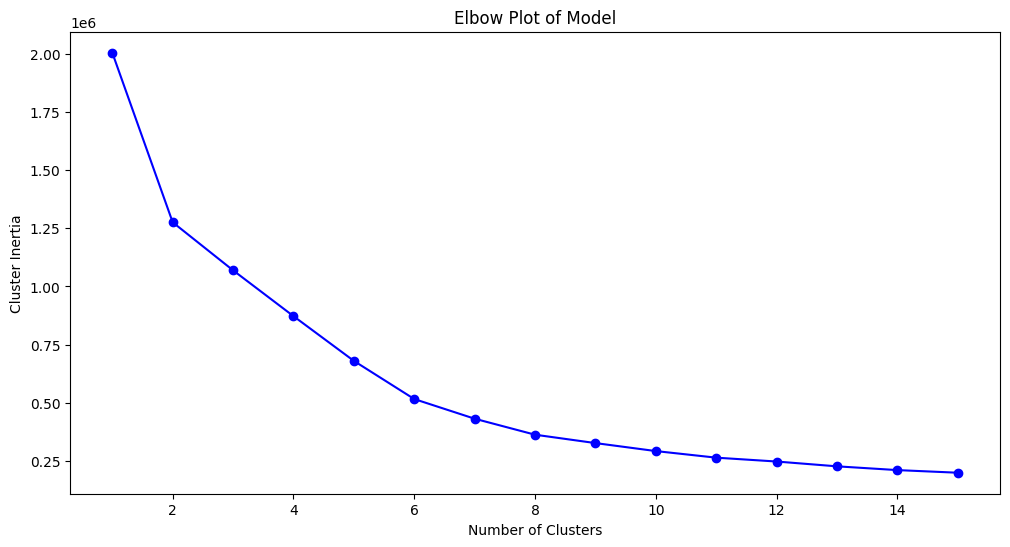

In [31]:
clusters_centers, k_values = find_optimal_clusters(g_company_type_df[feature_columns], 16)
generate_elbow_plot(clusters_centers, k_values)

> Cross-Validation

In [33]:
# K-Fold Cross Validation Test V1
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans

# Define the number of folds (K) In here I'm still not sure wheter we should use 10 or 5
k = 5

# Initialize the K-fold cross-validator
kfold = KFold(n_splits=k)

# Lists to store the cluster centers and K values
cluster_centers = []
k_values = []

# Iterate over the K-fold splits
for train_index, test_index in kfold.split(g_company_type_df[feature_columns]):
    # Get the training and testing data for this split
    X_train, X_test = g_company_type_df[feature_columns].iloc[train_index], g_company_type_df[feature_columns].iloc[test_index]

    # Implement the Elbow Method for each fold
    maximum_K = 10  # Maximum value of K
    fold_cluster_centers, fold_k_values = find_optimal_clusters(X_train, maximum_K)

    # Append the cluster centers and K values for this fold
    cluster_centers.append(fold_cluster_centers)
    k_values.append(fold_k_values)

# After the loop, you can analyze the cluster centers and K values for each fold and decide on the optimal number of clusters based on the Elbow Method

# Note: You can implement the find_optimal_clusters() function here or use the one you defined previously check ???

> Putting Into K-means Model

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
kmeans = KMeans(n_clusters=6, random_state=42)  # initialize the k-means model by using the optimal number of clusters found in the elbow method
kmeans.fit(X_train)                             # fit the k-means model to the training data
train_clusters = kmeans.predict(X_train)        # predict the clusters for the training data

c:\Users\emirh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


> Silhouette Score

In [ ]:
# calculating the silhouette score for the training data where X_train is trained data and train_clusters are the labels
silhouette_train = silhouette_score(X_train, train_clusters)

# print the silhouette score
print("Silhouette Score (Training):", silhouette_train)